# Prepare

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import pickle
sns.set()
%matplotlib inline

BASE_DIR = '../workspace/disambiguation'
TRAIN_AUTHOR_PATH = './data2/train/train_author.json'
TRAIN_PUB_PATH = './data2/train/train_pub.json'
WHOLE_AUTHOR_PROFILE_PATH = './data2/cna_data/whole_author_profile.json'
WHOLE_AUTHOR_PROFILE_PUB_PATH = './data2/cna_data/whole_author_profile_pub.json'
VALID_PUB_PATH = './data2/cna_data/cna_valid_pub.json'
VALID_UNASS_PATH = './data2/cna_data/cna_valid_unass_competition.json'
TEST_PUB_PATH = './final_dir/data/cna_test_pub.json'
TEST_UNASS_PATH = './final_dir/data/cna_test_unass_competition.json'
NEW_DATA_DIR = './new-data'          # original info, for test
NEW_DATA_V2_DIR = './new-data-v2'    # last 1 year info
NEW_DATA_V3_DIR = './new-data-v3'    # last 2 year info
NEW_DATA_V4_DIR = './new-data-v4'    # add paper count info
OUT_DIR_v2 = './out-v2'
SPLIT_DIR = './split-data'
TEST_FEATURE_DIR_V2 = './test-feature-v2'
STACK_MODEL_DIR_v2 = './stack_model_v2'

BASE_COLS = [
    'coauthors_count', 'coauthors_count_by_all_count', 'coauthors_count_by_this_coauthor_count',
    'this_paper_coauthor_count', 'this_paper_coathor_count_by_all_coauthor', 'this_paper_coauthor_count_by_this_paper_coauthor_count',
    'min_diff', 'max_diff', 'mean_diff', 'meadian_diff', 'min_max_avg_diff', 'is_in_range',
    'this_year_count', 'this_year_count_by_all_year', 'is_in_cate_range', 'before_one', 'before_two',
    'later_one', 'later_two', 'venue_max_score', 'venue_mean_score', 'venue_max_add_score',
    'venue_mean_add_score', 'venue_is_match', 'venue_score_add_score', 'org_max_score', 'org_mean_score',
    'org_max_add_score', 'org_mean_add_score', 'org_is_match', 'org_score_add_score', 'org_year_abs_diff',
    'keywords_max_score', 'keywords_mean_score', 'rela_year_diff', 'rela_coauthor_count',
    'rela_coauthor_count_by1', 'rela_coauthor_count_by2', 'rela_org_max_score',
    'rela_org_mean_score', 'rela_org_max_add_score', 'rela_org_mean_add_score',
    'rela_org_score_add_score', 'rela_venue_max_score', 'rela_venue_mean_score',
    'rela_venue_max_add_score', 'rela_venue_mean_add_score', 'rela_venue_score_add_score',
    'rela_keyword_max_score', 'rela_keyword_mean_score'
]
# length: 50
SET_INFO_COLS = [
    'org_set_count', 'org_set_count_by_all_count',
    'org_set_count_by_this_count', 'venue_word_count', 'venue_word_count_by_all_count',
    'venue_word_count_by_this_venue_count', 'keyword_count', 'keyword_count_by_all_count',
    'keyword_count_by_this_keyword_count'
]
# length: 9
TITLE_COLS = [
    'title'
]


def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)


def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# 原始数据EDA

### 同名作者数统计

All author name count:  320


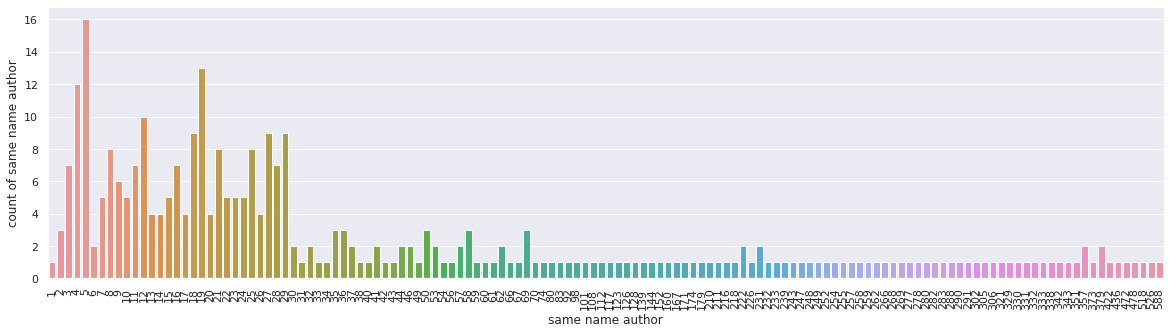

In [2]:
name2aids = load_pickle(os.path.join(BASE_DIR, NEW_DATA_DIR, 'name2aids.pkl'))
print('All author name count: ', len(name2aids.keys()))
data = []
for name in name2aids:
    aids = name2aids[name]
    data.append(len(aids))
df = pd.DataFrame(data=data, columns=['count'])
plt.figure(figsize=(20, 5))
sns.countplot(x='count', data=df)
plt.xlabel('same name author')
plt.ylabel('count of same name author')
plt.xticks(rotation='vertical')
plt.show()

### 论文年份统计

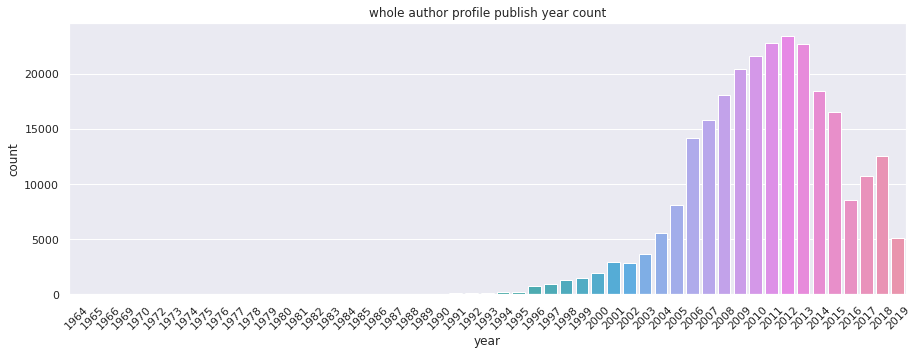

In [3]:
all_profile_pub = load_json(os.path.join(BASE_DIR, WHOLE_AUTHOR_PROFILE_PUB_PATH))
year_count = []
for pid in all_profile_pub:
    year = all_profile_pub[pid].get('year', '0')
    if year == '':
        year = 0
    else:
        year = int(year)
    if year <= 1500 or year >= 2100:
        year = 0
    if year != 0:
        year_count.append(year)
df = pd.DataFrame(data=year_count, columns=['year'])
plt.figure(figsize=(15, 5))
sns.countplot(x='year', data=df)
plt.xticks(rotation=45)
plt.title('whole author profile publish year count')
plt.show()

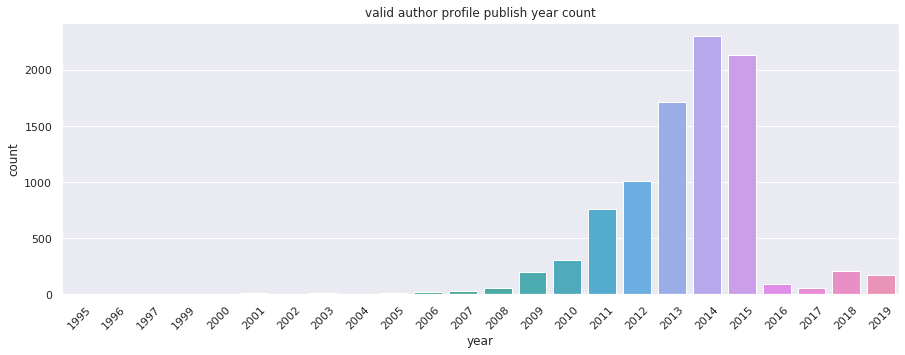

In [4]:
valid_pub = load_json(os.path.join(BASE_DIR, VALID_PUB_PATH))
year_count = []
for pid in valid_pub:
    year = valid_pub[pid].get('year', '0')
    if year == '':
        year = 0
    else:
        year = int(year)
    if year <= 1500 or year >= 2100:
        year = 0
    if year != 0:
        year_count.append(year)
df = pd.DataFrame(data=year_count, columns=['year'])
plt.figure(figsize=(15, 5))
sns.countplot(x='year', data=df)
plt.xticks(rotation=45)
plt.title('valid author profile publish year count')
plt.show()

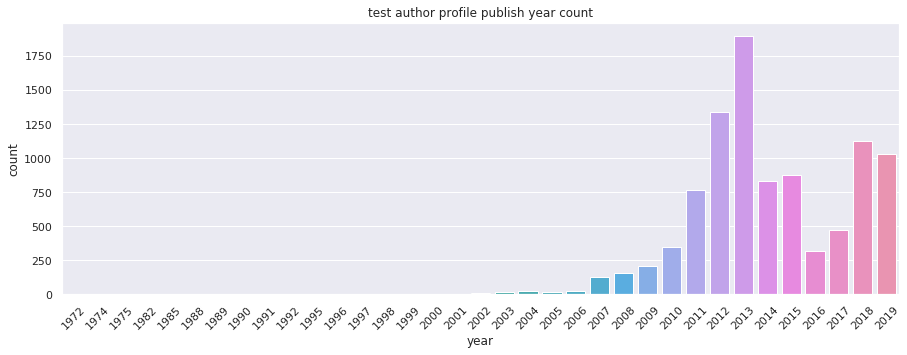

In [5]:
test_pub = load_json(os.path.join(BASE_DIR, TEST_PUB_PATH))
year_count = []
for pid in test_pub:
    year = test_pub[pid].get('year', '0')
    if year == '':
        year = 0
    else:
        year = int(year)
    if year <= 1500 or year >= 2100:
        year = 0
    if year != 0:
        year_count.append(year)
df = pd.DataFrame(data=year_count, columns=['year'])
plt.figure(figsize=(15, 5))
sns.countplot(x='year', data=df)
plt.xticks(rotation=45)
plt.title('test author profile publish year count')
plt.show()

# 提取特征EDA

### 特征 max_diff

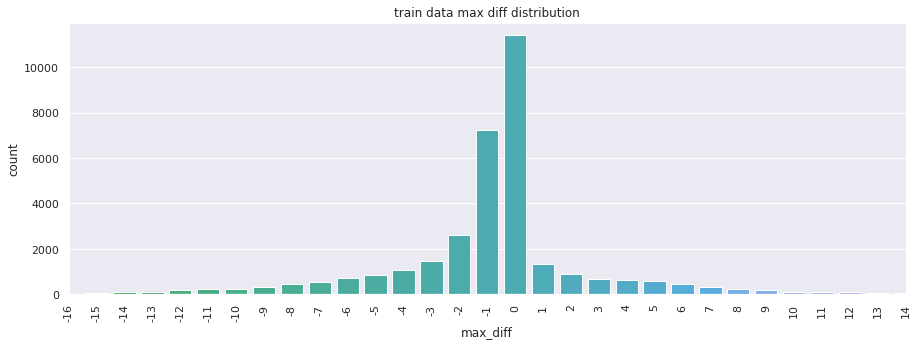

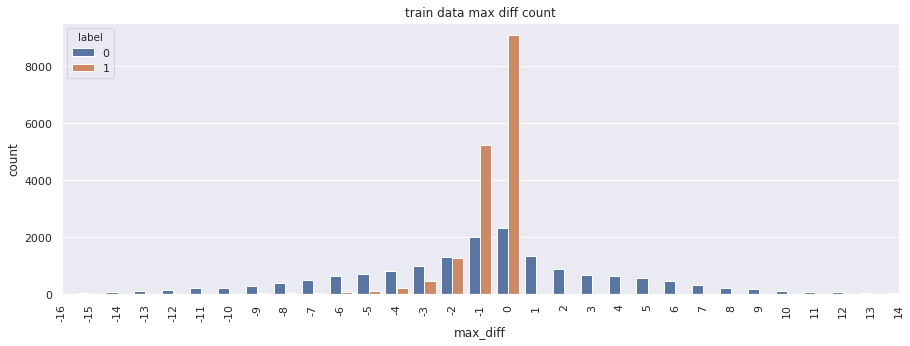

In [6]:
diff_year = []
train_df = load_pickle(os.path.join(BASE_DIR, NEW_DATA_V3_DIR, 'data-last1year-withsetinfo-extend1.pkl'))

plt.figure(figsize=(15, 5))
sns.countplot(x='max_diff', data=train_df)
# print(plt.xlim())
plt.xlim((23, 53))
plt.title('train data max diff distribution')
plt.xticks(rotation='vertical')
plt.show()


plt.figure(figsize=(15, 5))
sns.countplot(x='max_diff', data=train_df, hue='label')
# print(plt.xlim())
plt.xlim((23, 53))
plt.title('train data max diff count')
plt.xticks(rotation='vertical')
plt.show()

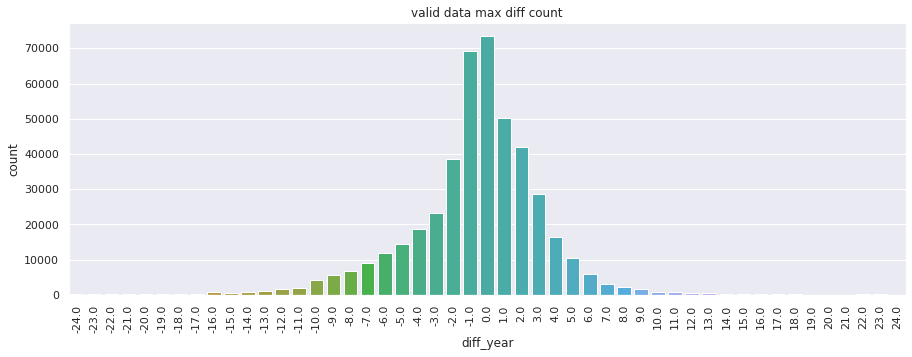

In [7]:
diff_year = []
df_dict = load_pickle(os.path.join(BASE_DIR, TEST_FEATURE_DIR_V2, 'testdatafeatures-withsetinfo.pkl'))
for pid_with_index in df_dict:
    data = df_dict[pid_with_index]['data']
    default_cols = BASE_COLS + SET_INFO_COLS
    df = pd.DataFrame(data=data, columns=default_cols)
    diff_year.extend(df['max_diff'].values.tolist())
df = pd.DataFrame(data=diff_year, columns=['diff_year'])
plt.figure(figsize=(15, 5))
sns.countplot(x='diff_year', data=df)
plt.title('valid data max diff count')
plt.xticks(rotation='vertical')
plt.show()

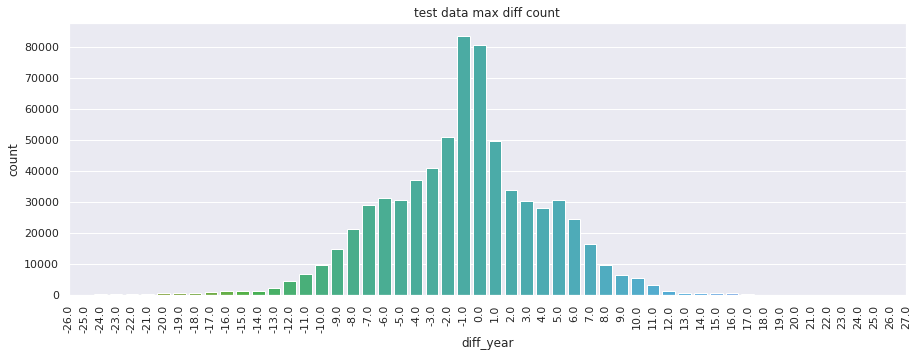

In [8]:
diff_year = []
df_dict = load_pickle(os.path.join(BASE_DIR, './final_dir/feature/testdatafeatures-withsetinfo.pkl'))
for pid_with_index in df_dict:
    data = df_dict[pid_with_index]['data']
    default_cols = BASE_COLS + SET_INFO_COLS
    df = pd.DataFrame(data=data, columns=default_cols)
    diff_year.extend(df['max_diff'].values.tolist())
df = pd.DataFrame(data=diff_year, columns=['diff_year'])
plt.figure(figsize=(15, 5))
sns.countplot(x='diff_year', data=df)
plt.title('test data max diff count')
plt.xticks(rotation='vertical')
plt.xlim(20, 73)
plt.show()

### 特征

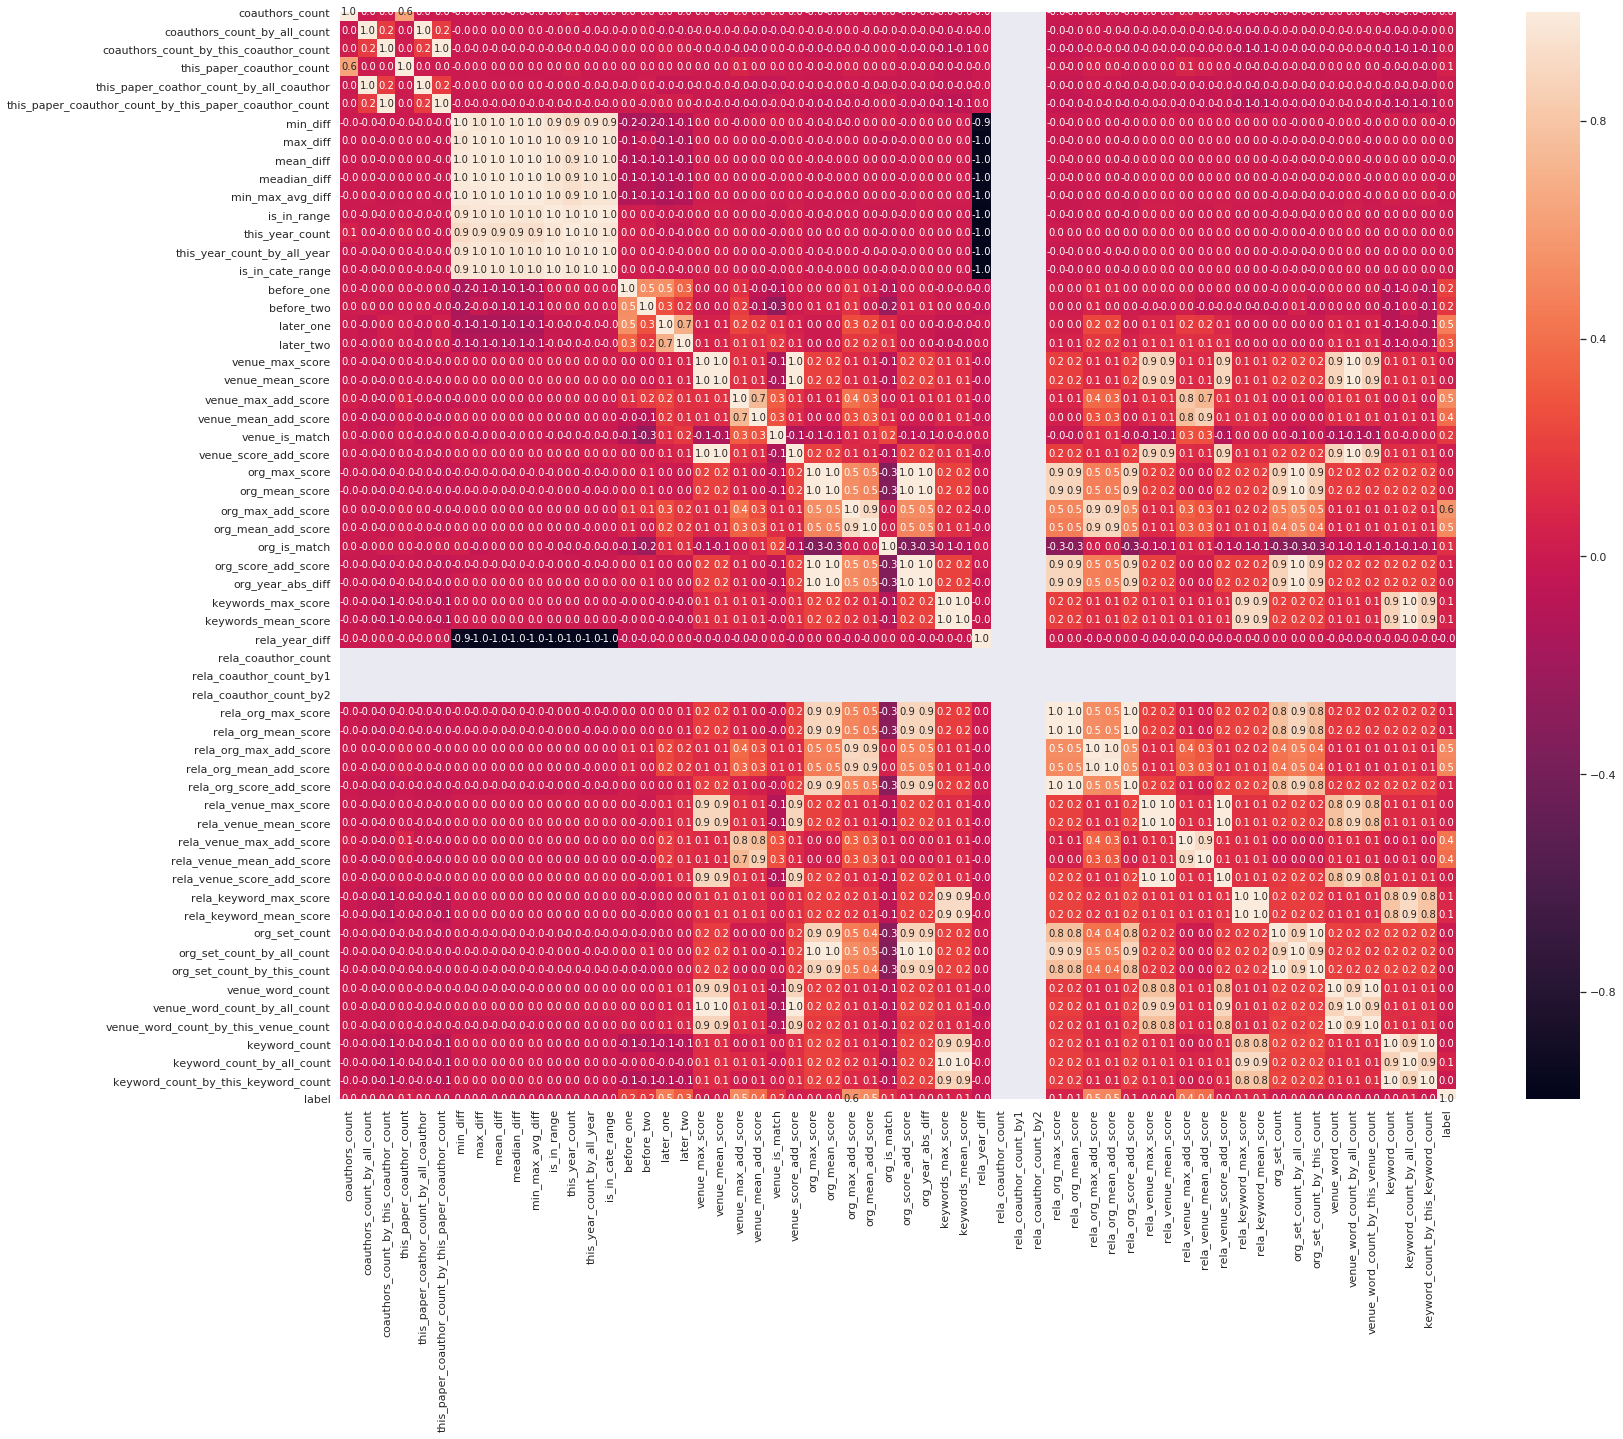

0    33423
Name: rela_coauthor_count, dtype: int64


In [9]:
train_df = load_pickle(os.path.join(BASE_DIR, NEW_DATA_V3_DIR, 'data-last1year-withsetinfo-extend1.pkl'))

plt.figure(figsize=(25, 20))
sns.heatmap(train_df.corr(), annot=True, fmt='.1f')
plt.show()

print(train_df['rela_coauthor_count'].value_counts())

### 特征重要性

(26738, 60)
(26738,)
(6685, 60)
(6685,)


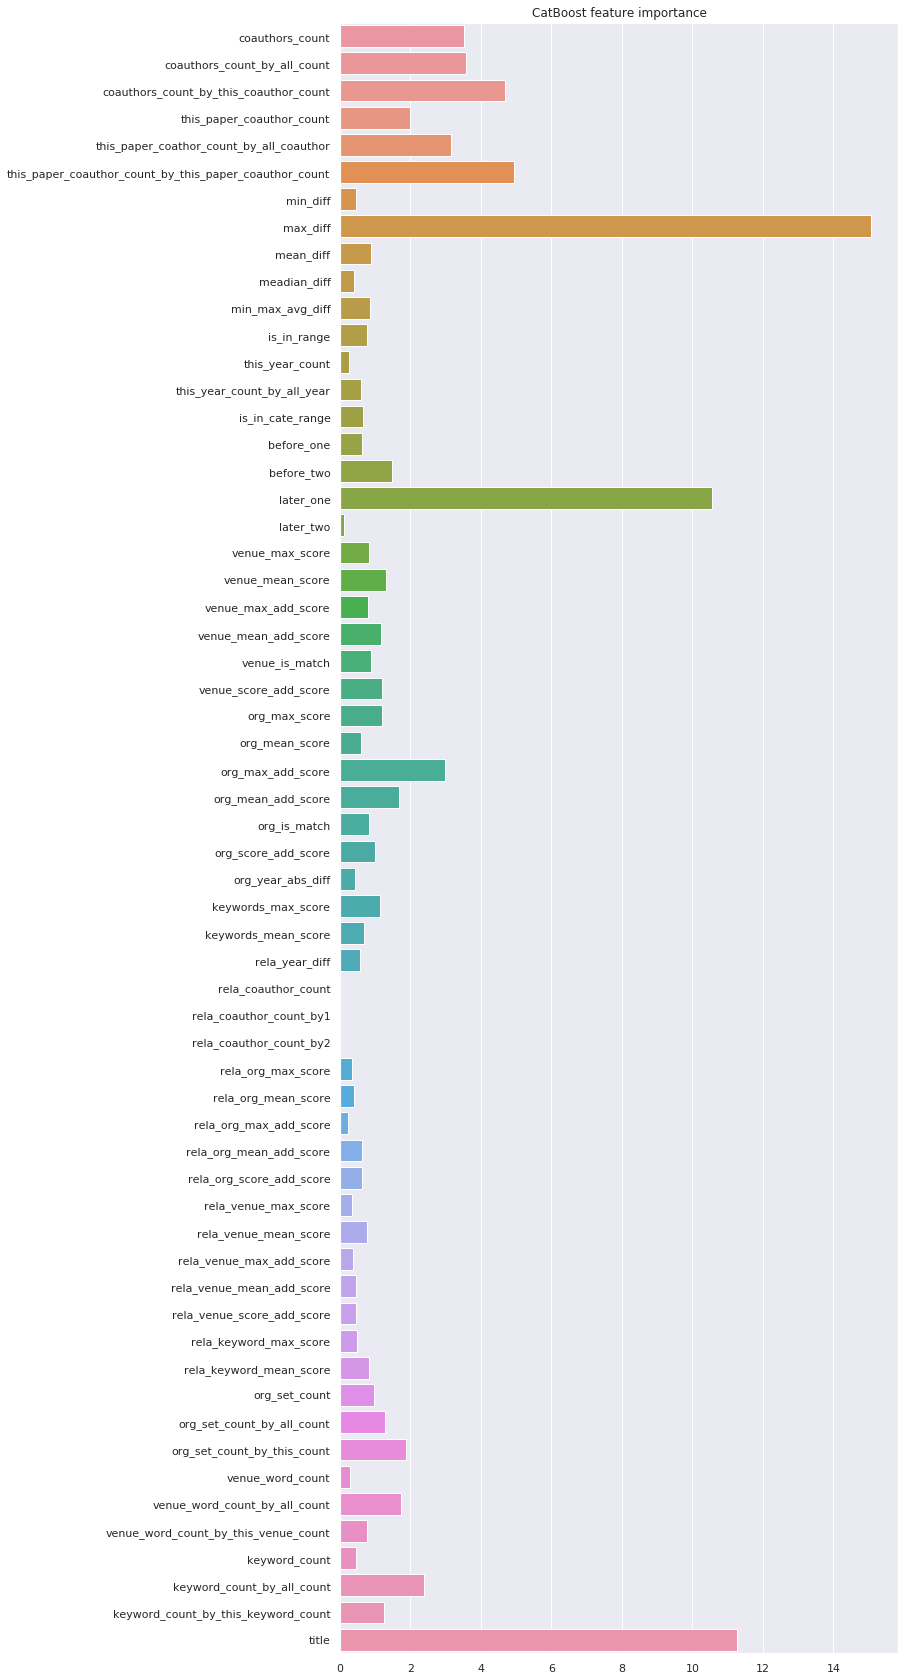

In [10]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
RANDOM_SEED=1129

df = pd.read_pickle(os.path.join(BASE_DIR, NEW_DATA_V3_DIR, 'data-last1year-withsetinfo-extend1.pkl'))
data_title_distance = pd.read_pickle(os.path.join(BASE_DIR, NEW_DATA_V3_DIR, 'data-title-distance-df.pkl'))
all_data = np.concatenate((df.values, data_title_distance.values.reshape(-1, 1)), axis=1)
df = pd.DataFrame(data=all_data, columns=list(df.columns) + list(data_title_distance.columns))
df = shuffle(df, random_state=1129)

useful_cols = BASE_COLS+SET_INFO_COLS+TITLE_COLS
train_data = df[useful_cols].values
train_y = df['label'].values
ss = StandardScaler()
train_data = ss.fit_transform(train_data)
train_x, val_x, train_y, val_y = train_test_split(train_data, train_y, test_size=0.2, random_state=1129)
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
model = CatBoostClassifier(
    iterations=320, learning_rate=0.05, depth=7, loss_function='Logloss',
    eval_metric='Logloss', task_type='GPU', random_seed=RANDOM_SEED
)
model.fit(train_x, train_y, verbose=0, eval_set=[(val_x, val_y)])
feature_importance = model.feature_importances_
plt.figure(figsize=(10, 30))
sns.barplot(x=feature_importance, y=useful_cols)
plt.title('CatBoost feature importance')
plt.show()

(26738, 60)
(26738,)
(6685, 60)
(6685,)


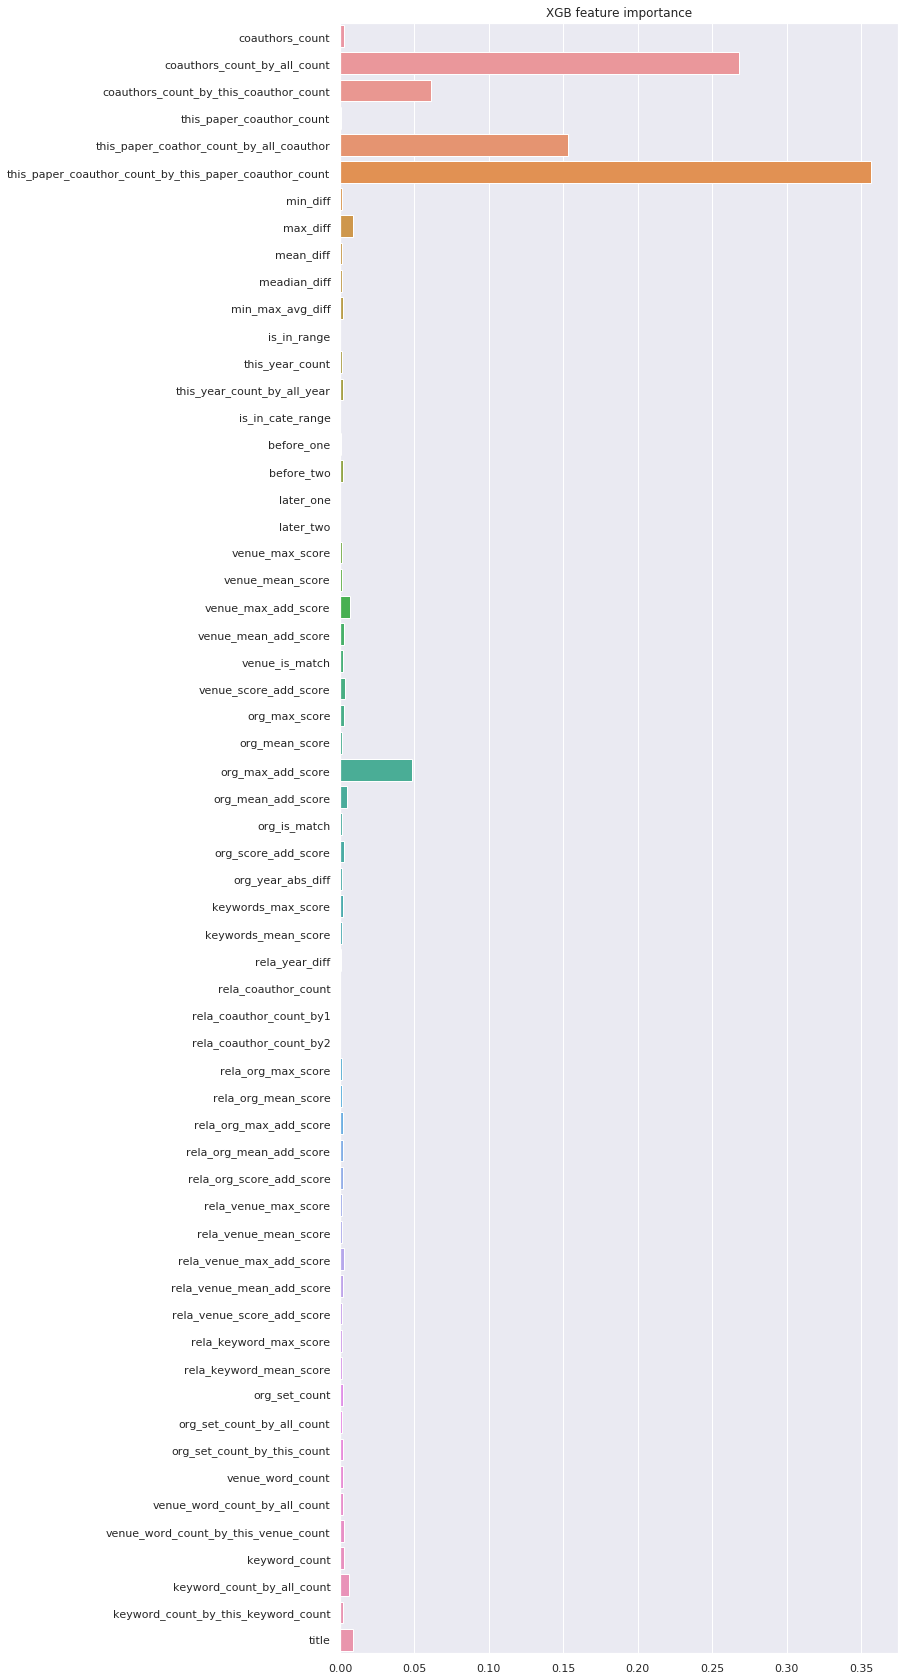

In [11]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
RANDOM_SEED=1129

df = pd.read_pickle(os.path.join(BASE_DIR, NEW_DATA_V3_DIR, 'data-last1year-withsetinfo-extend1.pkl'))
data_title_distance = pd.read_pickle(os.path.join(BASE_DIR, NEW_DATA_V3_DIR, 'data-title-distance-df.pkl'))
all_data = np.concatenate((df.values, data_title_distance.values.reshape(-1, 1)), axis=1)
df = pd.DataFrame(data=all_data, columns=list(df.columns) + list(data_title_distance.columns))
df = shuffle(df, random_state=1129)

useful_cols = BASE_COLS+SET_INFO_COLS+TITLE_COLS
train_data = df[useful_cols].values
train_y = df['label'].values
ss = StandardScaler()
train_data = ss.fit_transform(train_data)
train_x, val_x, train_y, val_y = train_test_split(train_data, train_y, test_size=0.2, random_state=1129)
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
model = XGBClassifier(
    max_depth=7, learning_rate=0.05, n_estimators=180, subsample=0.8,
    n_jobs=-1, min_child_weight=6, random_state=RANDOM_SEED
)
model.fit(train_x, train_y, verbose=0, eval_set=[(train_x, train_y), (val_x, val_y)], eval_metric='logloss')
feature_importance = model.feature_importances_
plt.figure(figsize=(10, 30))
sns.barplot(x=feature_importance, y=useful_cols)
plt.title('XGB feature importance')
plt.show()

(26738, 60)
(26738,)
(6685, 60)
(6685,)


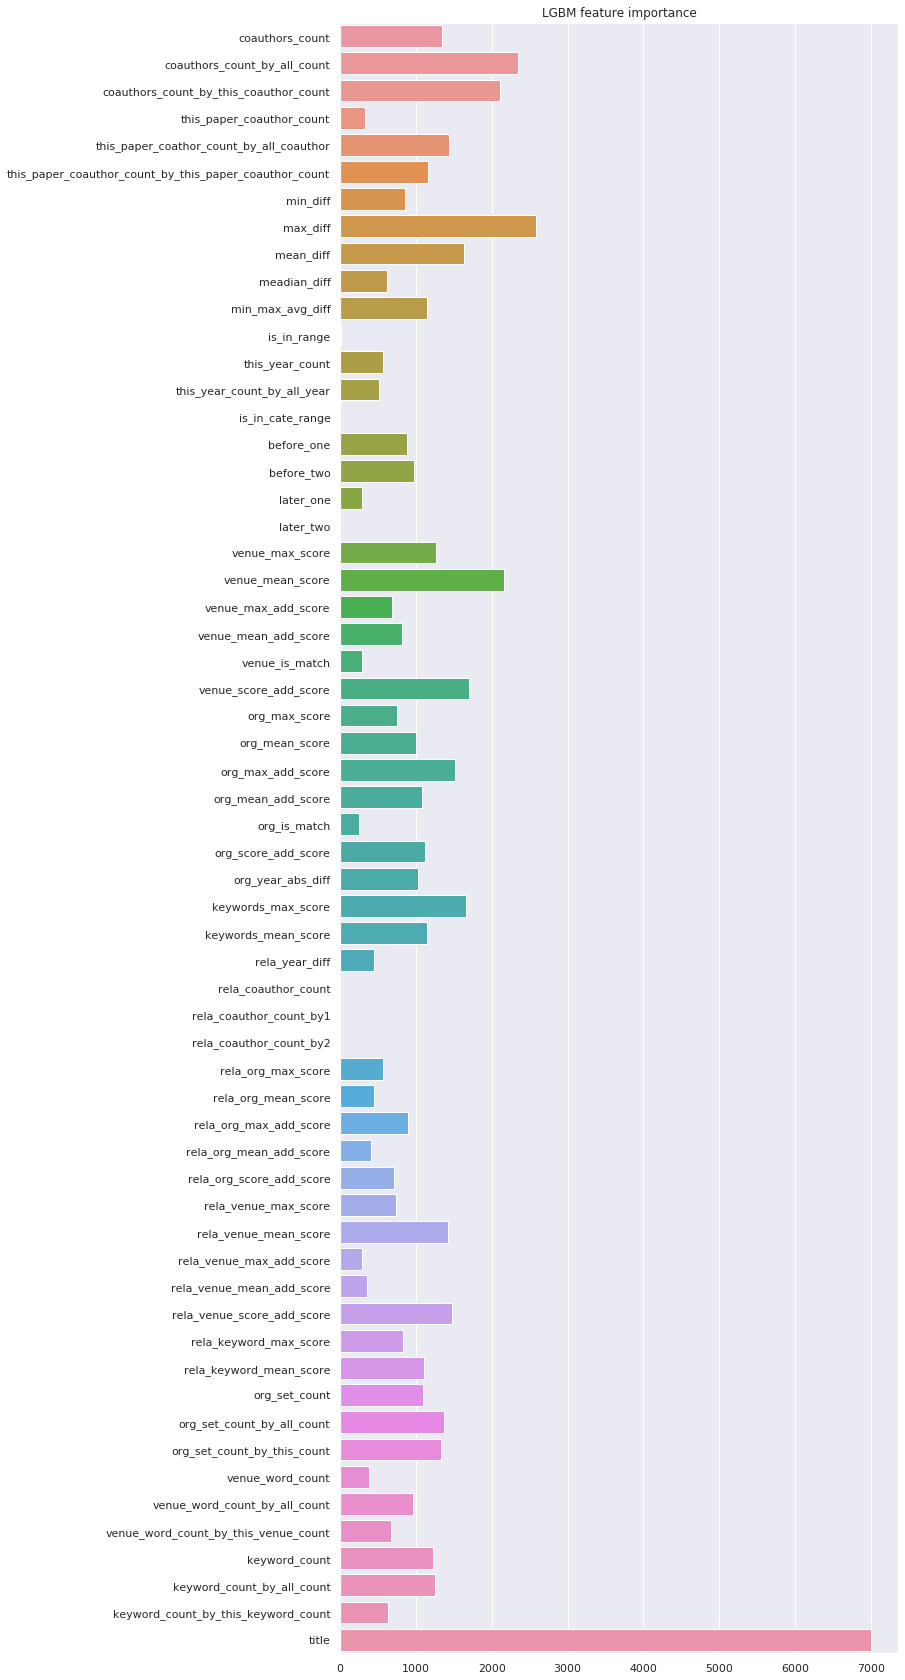

In [12]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
RANDOM_SEED=1129

df = pd.read_pickle(os.path.join(BASE_DIR, NEW_DATA_V3_DIR, 'data-last1year-withsetinfo-extend1.pkl'))
data_title_distance = pd.read_pickle(os.path.join(BASE_DIR, NEW_DATA_V3_DIR, 'data-title-distance-df.pkl'))
all_data = np.concatenate((df.values, data_title_distance.values.reshape(-1, 1)), axis=1)
df = pd.DataFrame(data=all_data, columns=list(df.columns) + list(data_title_distance.columns))
df = shuffle(df, random_state=1129)

useful_cols = BASE_COLS+SET_INFO_COLS+TITLE_COLS
train_data = df[useful_cols].values
train_y = df['label'].values
ss = StandardScaler()
train_data = ss.fit_transform(train_data)
train_x, val_x, train_y, val_y = train_test_split(train_data, train_y, test_size=0.2, random_state=1129)
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
model = LGBMClassifier(
    max_depth=7, learning_rate=0.01, n_estimators=1000, objective='binary',
    subsample=0.8, n_jobs=-1, num_leaves=82, random_state=RANDOM_SEED
)
model.fit(train_x, train_y, verbose=0, eval_set=[(train_x, train_y), (val_x, val_y)], eval_metric='logloss')
feature_importance = model.feature_importances_
plt.figure(figsize=(10, 30))
sns.barplot(x=feature_importance, y=useful_cols)
plt.title('LGBM feature importance')
plt.show()

(26738, 60)
(26738,)
(6685, 60)
(6685,)


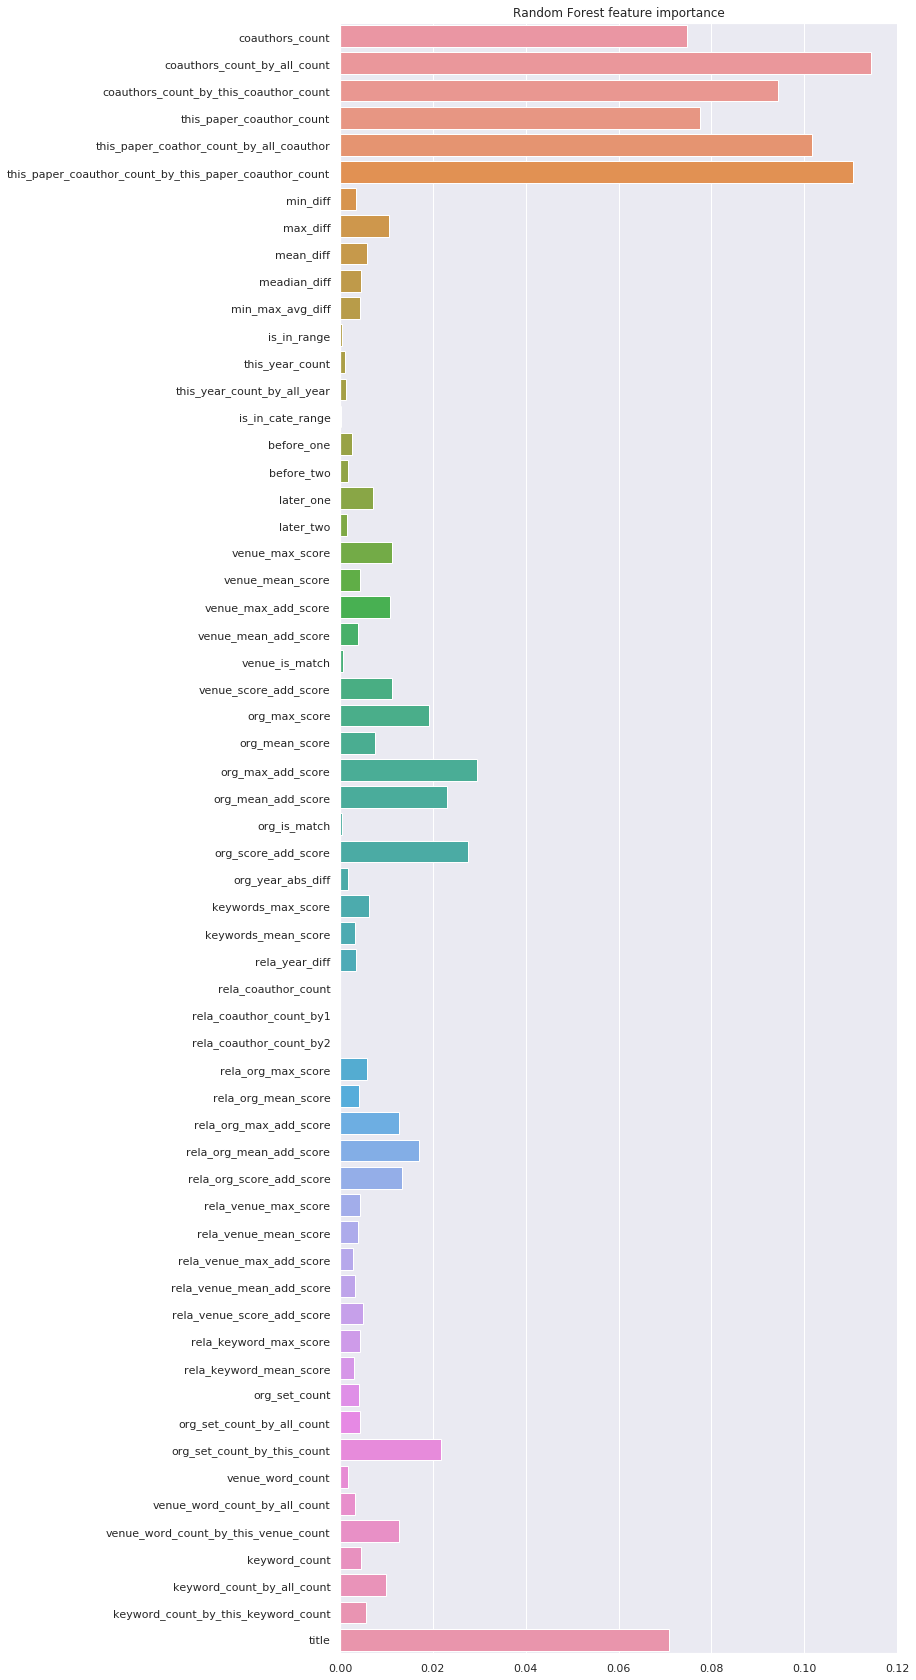

In [13]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
RANDOM_SEED=1129

df = pd.read_pickle(os.path.join(BASE_DIR, NEW_DATA_V3_DIR, 'data-last1year-withsetinfo-extend1.pkl'))
data_title_distance = pd.read_pickle(os.path.join(BASE_DIR, NEW_DATA_V3_DIR, 'data-title-distance-df.pkl'))
all_data = np.concatenate((df.values, data_title_distance.values.reshape(-1, 1)), axis=1)
df = pd.DataFrame(data=all_data, columns=list(df.columns) + list(data_title_distance.columns))
df = shuffle(df, random_state=1129)

useful_cols = BASE_COLS+SET_INFO_COLS+TITLE_COLS
train_data = df[useful_cols].values
train_y = df['label'].values
ss = StandardScaler()
train_data = ss.fit_transform(train_data)
train_x, val_x, train_y, val_y = train_test_split(train_data, train_y, test_size=0.2, random_state=1129)
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
model = RandomForestClassifier(
    n_estimators=1000, max_depth=60, n_jobs=-1, verbose=0, random_state=RANDOM_SEED
)
model.fit(train_x, train_y)
feature_importance = model.feature_importances_
plt.figure(figsize=(10, 30))
sns.barplot(x=feature_importance, y=useful_cols)
plt.title('Random Forest feature importance')
plt.show()